# Tugas UAS AI
Kelompok 5
- Muhammad Naufal Faza
- Michael Harditya
- Salma Dewi Taufiqoh

## Clone Github untuk Dataset
Github pribadi digunakan untuk menyimpan dataset agar mudah ditransfer jika dibutuhkan.

In [1]:
# !apt-get install git
!git clone https://github.com/GreyWard/image_classification_comparison
filepath = '/content/image_classification_comparison'

fatal: destination path 'image_classification_comparison' already exists and is not an empty directory.


## Import Library
Library atau modul-modul berikut diinstall menggunakan pip karena dibutuhkan untuk melakukan percobaan.

In [114]:
!pip install torch torchvision matplotlib numpy scikit-learn seaborn torchsummary

  Using cached pandas-2.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
Using cached pandas-2.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)


In [158]:
# Mengimpor modul yang diperlukan

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

# Modul untuk memuat dan membagi data
from torch.utils.data import DataLoader, random_split

# Modul untuk mengevaluasi kinerja model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Modul untuk visualisasi data
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Modul untuk operasi numerik
import numpy as np

# Modul untuk mengukur waktu komputasi
import time

# Mencetak ketersediaan GPU untuk komputasi
print(torch.cuda.is_available())

True


## Set Random Value
Mengatur `seed_value` agar hasil dari training memiliki keseragaman ketika diujikan kembali.

Dengan menetapkan nilai seed yang sama, hasil dari proses acak seperti inisialisasi bobot, pembagian data, dan lain-lain akan selalu sama setiap kali program dijalankan. Hal ini memungkinkan eksperimen dapat direproduksi dengan hasil yang identik.

In [159]:
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

## Data Preparation
Melakukan persiapan dari data, termasuk pembacaan gambar dan augmentasi.

Data augmentation digunakan untuk meningkatkan keanekaragaman data latih dan mencegah overfitting dengan membuat variasi gambar secara acak. Transformasi yang diterapkan seperti rotasi, pencerminan, perubahan warna, dan lain-lain dapat membantu model belajar fitur yang lebih umum dan robust.

In [160]:
# Mendefinisikan dimensi gambar yang akan digunakan

img_width, img_height = 224, 224

# Mendefinisikan transformasi data augmentation untuk data latih
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop((img_width, img_height)), # Memotong gambar ke ukuran yang diinginkan
        transforms.RandomHorizontalFlip(), # Membalik gambar secara horizontal secara acak
        transforms.RandomRotation(40), # Merotasi gambar secara acak dengan sudut maksimal 40 derajat
        transforms.RandomAffine(0, shear=0.1, scale=(0.8, 1)), # Menerapkan transformasi afin secara acak (shear dan scaling)
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Mengubah kecerahan, kontras, saturasi, dan hue gambar secara acak
        transforms.ToTensor(), # Mengonversi gambar menjadi tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Menormalisasi nilai piksel gambar
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((img_width, img_height)), # Mengubah ukuran gambar ke dimensi yang diinginkan
        transforms.ToTensor(), # Mengonversi gambar menjadi tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Menormalisasi nilai piksel gambar
    ]),
}



In [ ]:

# Esktrak dataset dari zip
# !unzip /content/image_classification_comparison/Dataset.zip
# !unzip image_classification_comparison/Dataset.zip
# dieksekusi sekali
# Load dataset
dataset = datasets.ImageFolder('Dataset', transform=data_transforms['train'])

Kode di bawah ini digunakan untuk memvisualisasikan sampel gambar dari setiap kelas
dalam dataset. Pertama, label kelas didefinisikan dalam variabel class_labels.
Kemudian, sebuah kamus class_images dibuat untuk menyimpan sampel gambar untuk setiap kelas.

Dataset diiterasi, dan setiap gambar disimpan dalam kamus class_images sesuai dengan kelasnya.
Setelah itu, untuk setiap kelas, kode menampilkan num_samples (5) gambar secara berdampingan
menggunakan fungsi imshow dari matplotlib.

Visualisasi ini membantu memahami distribusi data dan memberikan gambaran tentang
jenis gambar yang terdapat dalam setiap kelas.

In [ ]:
import matplotlib.pyplot as plt

# Mendefinisikan jumlah sampel gambar yang akan ditampilkan
num_samples = 5

# Mendefinisikan label kelas
class_labels = ['Batu', 'Gunting', 'Kertas', 'Lizard', 'Spock']

# Membuat dictionary untuk menyimpan sampel gambar untuk setiap kelas
class_images = {label: [] for label in class_labels}

# Mengiterasi dataset dan mengumpulkan sampel gambar untuk setiap kelas
for image, label in dataset:
    class_images[class_labels[label]].append(image)

# Menampilkan sampel gambar untuk setiap kelas
for label, images in class_images.items():
    print(f"Kelas: {label}")
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i].permute(1, 2, 0))

        plt.axis('off')
    plt.show()



Kode di bawah ini membagi dataset menjadi tiga subset: pelatihan, validasi, dan pengujian.
Pembagian dilakukan dengan rasio 80% untuk pelatihan, 10% untuk validasi, dan 10% untuk pengujian.

Fungsi random_split dari PyTorch digunakan untuk membagi dataset secara acak sesuai dengan ukuran yang diinginkan.
Setelah pembagian, transformasi data augmentation yang sesuai diterapkan pada setiap subset data.

Kemudian, DataLoader dibuat untuk setiap subset data. DataLoader memungkinkan pembacaan data secara efisien
dan memungkinkan penggunaan teknik seperti mini-batch dan paralelisasi.

Parameter batch_size menentukan ukuran batch yang akan digunakan selama pelatihan dan evaluasi.
Parameter shuffle mengacak urutan data saat digunakan untuk pelatihan, tetapi tidak untuk validasi dan pengujian.
Parameter num_workers menentukan jumlah proses yang akan digunakan untuk memuat data secara paralel.

In [ ]:
# Membuat pembagian data untuk pelatihan, validasi, dan pengujian:
# 80% untuk pelatihan, 10% untuk validasi, 10% untuk pengujian
train_size = int(0.8 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = int(0.5 * val_test_size)
test_size = val_test_size - val_size

train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Menerapkan transformasi yang sesuai pada setiap subset data
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val_test']
test_dataset.dataset.transform = data_transforms['val_test']

# Membuat DataLoader untuk setiap subset data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)



In [156]:
train_size

1456

Kode di bawah ini menggunakan informasi dari dataset pelatihan untuk mendapatkan jumlah kelas
dan label kelas yang ada dalam dataset.

Jumlah kelas diperoleh dengan menghitung panjang atribut classes dari objek dataset pelatihan.
Atribut ini berisi daftar label kelas yang ada dalam dataset.

Label kelas dicetak dengan mengiterasi daftar class_labels yang diperoleh dari atribut classes
dari objek dataset pelatihan.

Informasi ini penting untuk memahami struktur dataset dan membantu dalam mempersiapkan
model untuk tugas klasifikasi multi-kelas.

In [ ]:
# Mendapatkan jumlah kelas dari dataset pelatihan
num_classes = len(train_dataset.dataset.classes)
print(f"Jumlah kelas: {num_classes}")

# Mendapatkan label kelas dari dataset pelatihan
class_labels = train_dataset.dataset.classes
print("Label kelas:")
for label in class_labels:
    print(label)

Kode di bawah ini menghitung jumlah sampel untuk setiap kelas dalam subset data pelatihan, validasi, dan pengujian.
Pertama, kamus train_class_counts, val_class_counts, dan test_class_counts diinisialisasi dengan nilai awal 0 untuk setiap kelas.

Kemudian, kode mengiterasi setiap subset data dan menghitung jumlah sampel untuk setiap kelas dengan menambahkannya ke kamus yang sesuai.

Setelah itu, dataframe dibuat menggunakan library pandas. Dataframe ini berisi informasi jumlah sampel per kelas untuk setiap subset data.

Kolom 'Class' berisi label kelas, sedangkan kolom 'Train Count', 'Validation Count', dan 'Test Count'
berisi jumlah sampel untuk setiap kelas dalam subset data yang sesuai.

Dataframe ini membantu memvisualisasikan distribusi kelas dalam dataset dan memastikan tidak ada kelas yang jauh lebih sedikit sampelnya dibandingkan kelas lain.
Informasi ini penting untuk mendeteksi ketidakseimbangan kelas yang dapat mempengaruhi kinerja model.

In [157]:
import pandas as pd

# Inisialisasi dictionary untuk menghitung jumlah sampel per kelas untuk setiap subset data
train_class_counts = {label: 0 for label in class_labels}
val_class_counts = {label: 0 for label in class_labels}
test_class_counts = {label: 0 for label in class_labels}

# Menghitung jumlah sampel per kelas untuk dataset pelatihan
for _, label in train_dataset:
    train_class_counts[class_labels[label]] += 1

# Menghitung jumlah sampel per kelas untuk dataset validasi
for _, label in val_dataset:
    val_class_counts[class_labels[label]] += 1

# Menghitung jumlah sampel per kelas untuk dataset pengujian
for _, label in test_dataset:
    test_class_counts[class_labels[label]] += 1

# Membuat dataframe untuk menyimpan informasi jumlah sampel per kelas
df = pd.DataFrame({
    'Class': class_labels,
    'Train Count': list(train_class_counts.values()),
    'Validation Count': list(val_class_counts.values()),
    'Test Count': list(test_class_counts.values())
})

# Mencetak dataframe
print(df)



     Class  Train Count  Validation Count  Test Count
0     Batu          257                37          44
1  Gunting          293                38          26
2   Kertas          343                38          43
3   Lizard          281                35          36
4    Spock          282                34          34


## Percobaan Pertama: AlexNet, VGG16, ResNet50

Dalam proses transfer learning pada dataset baru yang memiliki jumlah kelas yang berbeda dengan dataset ImageNet, diperlukan modifikasi pada lapisan classifier. Pada kode yang disajikan, lapisan classifier pada arsitektur ResNet, AlexNet, dan VGG mengalami perubahan. Dikarenakan struktur lapisan dense pada ResNet berbeda dengan AlexNet dan VGG, maka pendekatan yang digunakan untuk memodifikasi lapisan classifier pada masing-masing arsitektur tersebut juga berbeda.

Dalam konteks transfer learning, modifikasi lapisan classifier merupakan langkah penting untuk menyesuaikan model dengan tugas klasifikasi baru yang memiliki jumlah kelas yang berbeda dari tugas klasifikasi sebelumnya. Hal ini dilakukan dengan mengganti lapisan terakhir dari model yang bertanggung jawab untuk memprediksi kelas-kelas output sesuai dengan jumlah kelas pada dataset baru.

Fungsi ini digunakan untuk mengganti lapisan klasifikasi terakhir dari model yang telah dilatih sebelumnya
dengan lapisan baru yang sesuai dengan jumlah kelas pada tugas klasifikasi yang diinginkan.

Argumen yang diterima oleh fungsi ini adalah:
- model: Objek model PyTorch yang akan dimodifikasi.
- num_classes: Jumlah kelas pada tugas klasifikasi baru (default: 3).

Fungsi ini memeriksa jenis arsitektur model yang diberikan (ResNet, AlexNet, atau VGG).
Jika model adalah ResNet, lapisan terakhir (model.fc) diganti dengan lapisan baru yang terdiri dari:
1. Lapisan linear dengan 128 unit tersembunyi
2. Lapisan aktivasi ReLU
3. Lapisan dropout dengan rasio 0.5
4. Lapisan linear dengan jumlah unit sama dengan jumlah kelas yang diinginkan

Jika model adalah AlexNet atau VGG, lapisan terakhir dari klasifikator (model.classifier[6]) diganti dengan lapisan baru
yang memiliki struktur yang sama seperti pada kasus ResNet.

Jika arsitektur model tidak didukung, fungsi akan melemparkan ValueError.

Fungsi ini memungkinkan Anda untuk menggunakan model yang telah dilatih sebelumnya pada tugas klasifikasi yang berbeda
dengan jumlah kelas yang berbeda, hanya dengan mengganti lapisan klasifikasi terakhir.

In [122]:
def replace_classifier(model, num_classes=3):
    if isinstance(model, models.ResNet):
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    elif isinstance(model, (models.AlexNet, models.VGG)):
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    else:
        raise ValueError("Arsitektur model tidak didukung pada program ini")
    return model

In [123]:
def create_model(model_name="alexnet", num_classes=3):
    if model_name == "alexnet":
        model = models.alexnet(pretrained=True)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
    else:
        raise ValueError("Model tidak valid. Ganti ke 'alexnet', 'vgg16', or 'resnet50'.")

    model = replace_classifier(model, num_classes)
    return model

In [12]:
# Inisialisasi tiap model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = create_model("alexnet",num_classes).to(device)
vgg16_model = create_model("vgg16",num_classes).to(device)
resnet50_model = create_model("resnet50",num_classes).to(device)

/home/serverai/miniconda3/envs/uas-ai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/serverai/miniconda3/envs/uas-ai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/serverai/miniconda3/envs/uas-ai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can al

## Train and Evaluate Models


Kode di bawah ini merupakan fungsi untuk melakukan pelatihan dan evaluasi model pada dataset pelatihan dan validasi. Berikut adalah penjelasan untuk setiap baris kode secara radikal dan akademis:

1. Fungsi `train_model` menerima beberapa argumen: `model` (objek model PyTorch yang akan dilatih), `train_loader` (objek DataLoader untuk data pelatihan), `val_loader` (objek DataLoader untuk data validasi), `criterion` (fungsi loss yang digunakan), `optimizer` (algoritma optimasi yang digunakan), dan `num_epochs` (jumlah epoch pelatihan, default: 10).

2. Kamus `history` diinisialisasi untuk menyimpan sejarah loss dan akurasi selama pelatihan dan validasi.

3. Nilai seed ditetapkan untuk menjamin reproduktibilitas eksperimen, baik untuk PyTorch maupun NumPy.

4. Waktu awal pelatihan dicatat menggunakan fungsi `time.time()`.

5. Perulangan dilakukan sebanyak `num_epochs` kali.

6. Model diatur dalam mode pelatihan dengan memanggil `model.train()`.

7. Variabel `running_loss` dan `running_corrects` diinisialisasi untuk menyimpan jumlah loss dan jumlah prediksi yang benar selama iterasi pada epoch tersebut.

8. Perulangan dilakukan pada setiap batch data pelatihan yang diberikan oleh `train_loader`.

9. Data input dan label dipindahkan ke perangkat yang digunakan (CPU atau GPU) menggunakan metode `to(device)`.

10. Gradien optimizer direset menjadi nol dengan memanggil `optimizer.zero_grad()`.

11. Forward pass dilakukan melalui model dengan memanggil `model(inputs)`, dan output diperoleh.

12. Prediksi dilakukan dengan mencari nilai maksimum pada setiap baris output menggunakan `torch.max(outputs, 1)`.

13. Loss dihitung menggunakan fungsi loss `criterion` dengan membandingkan output model dan label sebenarnya.

14. Backward pass dilakukan dengan memanggil `loss.backward()` untuk menghitung gradien.

15. Bobot model diperbarui dengan memanggil `optimizer.step()`.

16. Jumlah loss dan jumlah prediksi yang benar selama iterasi diakumulasikan dalam `running_loss` dan `running_corrects`.

17. Rata-rata loss dan akurasi untuk epoch tersebut dihitung dengan membagi `running_loss` dan `running_corrects` dengan jumlah total data dalam `train_loader.dataset`.

18. Loss dan akurasi pelatihan disimpan dalam `history` untuk epoch tersebut.

19. Model diatur dalam mode evaluasi dengan memanggil `model.eval()`.

20. Variabel `val_loss` dan `val_corrects` diinisialisasi untuk menyimpan jumlah loss dan jumlah prediksi yang benar selama evaluasi pada data validasi.

21. Evaluasi dilakukan pada data validasi tanpa memperbarui bobot menggunakan `with torch.no_grad():`.

22. Proses yang sama seperti pada pelatihan dilakukan untuk menghitung loss dan akurasi pada data validasi.

23. Rata-rata loss dan akurasi validasi dihitung dengan membagi `val_loss` dan `val_corrects` dengan jumlah total data dalam `val_loader.dataset`.

24. Loss dan akurasi validasi disimpan dalam `history` untuk epoch tersebut.

25. Loss dan akurasi pelatihan serta validasi dicetak untuk setiap epoch.

26. Waktu akhir pelatihan dicatat menggunakan `time.time()`, dan waktu yang dibutuhkan untuk pelatihan dihitung dengan mengurangi waktu akhir dengan waktu awal.

27. Waktu yang dibutuhkan untuk pelatihan dicetak dalam format menit dan detik.

28. Model yang telah dilatih dan sejarah loss serta akurasi selama pelatihan dan validasi dikembalikan oleh fungsi.

Fungsi `train_model` ini merupakan inti dari proses pelatihan dan evaluasi model pada dataset pelatihan dan validasi. Fungsi ini melakukan sejumlah iterasi pelatihan dan evaluasi sebanyak `num_epochs` kali, dengan memperbarui bobot model pada setiap iterasi pelatihan dan menghitung loss serta akurasi pada data pelatihan dan validasi. Sejarah loss dan akurasi disimpan dalam kamus `history` untuk memudahkan visualisasi dan analisis kinerja model selama proses pelatihan.

Dengan menggunakan fungsi ini, kita dapat melakukan pelatihan model secara efisien dan mendapatkan informasi penting tentang kinerja model pada setiap epoch, serta waktu yang dibutuhkan untuk menyelesaikan proses pelatihan. Informasi ini sangat bermanfaat untuk memantau proses pelatihan dan mengoptimalkan kinerja model.

In [125]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Menginisialisasi kamus untuk menyimpan sejarah loss dan akurasi selama pelatihan dan validasi
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Menetapkan nilai seed untuk menjamin reproduktibilitas eksperimen
    seed_value = 42
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    
    # Mencatat waktu awal pelatihan
    start_time = time.time()
    
    for epoch in range(num_epochs):
        
        # Mengatur model dalam mode pelatihan
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Melakukan iterasi pada setiap batch data pelatihan
        for inputs, labels in train_loader:
            # Memindahkan data ke perangkat yang digunakan (CPU atau GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Mereset gradien optimizer
            optimizer.zero_grad()

            # Melakukan forward pass melalui model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Menghitung loss
            loss = criterion(outputs, labels)

            # Melakukan backward pass dan memperbarui bobot
            loss.backward()
            optimizer.step()

            # Menghitung jumlah loss dan prediksi yang benar selama iterasi
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Menghitung rata-rata loss dan akurasi untuk epoch tersebut
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        # Menyimpan loss dan akurasi pelatihan ke dalam sejarah
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # Mengatur model dalam mode evaluasi
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        # Melakukan evaluasi pada data validasi tanpa memperbarui bobot
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        # Menghitung rata-rata loss dan akurasi validasi
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        
        # Menyimpan loss dan akurasi validasi ke dalam sejarah
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Mencetak loss dan akurasi pelatihan dan validasi setiap epoch
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
    
    # Mencatat waktu akhir pelatihan dan menghitung waktu yang dibutuhkan
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    
    # Mengembalikan model yang telah dilatih dan sejarah loss serta akurasi
    return model, history

In [146]:
def evaluate_model(model, test_loader, class_labels):
    # Menetapkan nilai seed untuk menjamin reproduktibilitas eksperimen
    seed_value = 42
    torch.manual_seed(seed_value)
    np.random.seed(seed_value)
    
    # Mengatur model dalam mode evaluasi
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = [] # Menyimpan semua output untuk perhitungan AUC-ROC

    # Melakukan evaluasi tanpa memperbarui bobot model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())  # Menyimpan output

    # Menghitung akurasi
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    # Membuat confusion matrix dan memvisualisasikannya dengan heatmap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Mencetak classification report (presisi, recall, F1-score)
    print(classification_report(all_labels, all_preds, target_names=class_labels))

    
    # Menghitung dan memvisualisasikan kurva AUC-ROC (One-vs-Rest untuk multi-kelas)
    y_true_bin = label_binarize(all_labels, classes=np.arange(len(class_labels)))
    y_pred_bin = torch.softmax(torch.tensor(all_outputs), dim=1).numpy() 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Menghitung kurva ROC untuk setiap kelas
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Memplot kurva ROC untuk setiap kelas
    plt.figure(figsize=(10, 7))
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.5f})')

    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy

In [15]:
# Hyperparameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
alexnet_optimizer = optim.Adam(alexnet_model.classifier.parameters(), lr=0.001)
vgg16_optimizer = optim.Adam(vgg16_model.classifier.parameters(), lr=0.001)
resnet50_optimizer = optim.Adam(resnet50_model.fc.parameters(), lr=0.001)

In [16]:
# Train dan evaluasi AlexNet
print("--- Training AlexNet ---")
alexnet_model, alexnet_history = train_model(alexnet_model, train_loader, val_loader, criterion, alexnet_optimizer, num_epochs)
alexnet_accuracy = evaluate_model(alexnet_model, test_loader)
# Save model
torch.save(alexnet_model,'finetuned_alexnet.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del alexnet_model
print(f"AlexNet Accuracy on Test Set: {alexnet_accuracy:.4f}")

--- Training AlexNet ---
Epoch 0/49 Loss: 1.5002 Acc: 0.3345 Val Loss: 1.1264 Val Acc: 0.4231
Epoch 1/49 Loss: 1.1520 Acc: 0.4760 Val Loss: 0.9618 Val Acc: 0.5714
Epoch 2/49 Loss: 1.0350 Acc: 0.5330 Val Loss: 0.8303 Val Acc: 0.5440
Epoch 3/49 Loss: 0.9326 Acc: 0.5831 Val Loss: 0.7121 Val Acc: 0.6813
Epoch 4/49 Loss: 0.8910 Acc: 0.6429 Val Loss: 0.6890 Val Acc: 0.6978
Epoch 5/49 Loss: 0.8181 Acc: 0.6600 Val Loss: 0.6005 Val Acc: 0.7308
Epoch 6/49 Loss: 0.8548 Acc: 0.6422 Val Loss: 0.8106 Val Acc: 0.6209
Epoch 7/49 Loss: 0.7880 Acc: 0.6882 Val Loss: 0.5521 Val Acc: 0.7527
Epoch 8/49 Loss: 0.7272 Acc: 0.7170 Val Loss: 0.5679 Val Acc: 0.7253
Epoch 9/49 Loss: 0.6909 Acc: 0.7383 Val Loss: 0.5644 Val Acc: 0.7473
Epoch 10/49 Loss: 0.6975 Acc: 0.7287 Val Loss: 0.5382 Val Acc: 0.8132
Epoch 11/49 Loss: 0.6675 Acc: 0.7603 Val Loss: 0.4556 Val Acc: 0.8187
Epoch 12/49 Loss: 0.6433 Acc: 0.7699 Val Loss: 0.4307 Val Acc: 0.8022
Epoch 13/49 Loss: 0.6571 Acc: 0.7734 Val Loss: 0.4639 Val Acc: 0.8022
Epoch

In [17]:
# Train dan evaluasi VGG16
print("--- Training VGG16 ---")
vgg16_model, vgg16_history = train_model(vgg16_model, train_loader, val_loader, criterion, vgg16_optimizer, num_epochs)
vgg16_accuracy = evaluate_model(vgg16_model, test_loader)
# Save model
torch.save(vgg16_model, 'finetuned_vgg16.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del vgg16_model
print(f"VGG16 Accuracy on Test Set: {vgg16_accuracy:.4f}")

--- Training VGG16 ---
Epoch 0/49 Loss: 1.5060 Acc: 0.3359 Val Loss: 1.0762 Val Acc: 0.4945
Epoch 1/49 Loss: 1.1552 Acc: 0.5007 Val Loss: 0.9573 Val Acc: 0.5110
Epoch 2/49 Loss: 0.9588 Acc: 0.5934 Val Loss: 0.7619 Val Acc: 0.6538
Epoch 3/49 Loss: 0.7692 Acc: 0.6902 Val Loss: 0.6700 Val Acc: 0.7418
Epoch 4/49 Loss: 0.7618 Acc: 0.7060 Val Loss: 0.6244 Val Acc: 0.6978
Epoch 5/49 Loss: 0.6765 Acc: 0.7321 Val Loss: 0.5524 Val Acc: 0.7747
Epoch 6/49 Loss: 0.6096 Acc: 0.7898 Val Loss: 0.3415 Val Acc: 0.8956
Epoch 7/49 Loss: 0.7638 Acc: 0.7109 Val Loss: 0.4243 Val Acc: 0.8132
Epoch 8/49 Loss: 0.5621 Acc: 0.7981 Val Loss: 0.4123 Val Acc: 0.8462
Epoch 9/49 Loss: 0.5246 Acc: 0.8228 Val Loss: 0.3356 Val Acc: 0.9176
Epoch 10/49 Loss: 0.5388 Acc: 0.8221 Val Loss: 0.3201 Val Acc: 0.8462
Epoch 11/49 Loss: 0.5219 Acc: 0.8228 Val Loss: 0.2730 Val Acc: 0.9121
Epoch 12/49 Loss: 0.4874 Acc: 0.8620 Val Loss: 0.2934 Val Acc: 0.9066
Epoch 13/49 Loss: 0.5322 Acc: 0.8317 Val Loss: 0.3021 Val Acc: 0.9176
Epoch 1

In [18]:
# Train dan evaluasi ResNet50
print("--- Training ResNet50 ---")
resnet50_model, resnet50_history = train_model(resnet50_model, train_loader, val_loader, criterion, resnet50_optimizer, num_epochs)
resnet50_accuracy = evaluate_model(resnet50_model, test_loader)
# Save model
torch.save(resnet50_model, 'finetuned_resnet50.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del resnet50_model
print(f"ResNet50 Accuracy on Test Set: {resnet50_accuracy:.4f}")

--- Training ResNet50 ---
Epoch 0/49 Loss: 1.5948 Acc: 0.3098 Val Loss: 1.3923 Val Acc: 0.5934
Epoch 1/49 Loss: 1.3495 Acc: 0.4629 Val Loss: 1.2168 Val Acc: 0.6099
Epoch 2/49 Loss: 1.2195 Acc: 0.5309 Val Loss: 1.0518 Val Acc: 0.6044
Epoch 3/49 Loss: 1.1405 Acc: 0.5398 Val Loss: 0.9695 Val Acc: 0.6758
Epoch 4/49 Loss: 1.0222 Acc: 0.6037 Val Loss: 0.8586 Val Acc: 0.7198
Epoch 5/49 Loss: 0.9781 Acc: 0.6202 Val Loss: 0.8321 Val Acc: 0.7418
Epoch 6/49 Loss: 0.9118 Acc: 0.6641 Val Loss: 0.7561 Val Acc: 0.7253
Epoch 7/49 Loss: 0.9219 Acc: 0.6470 Val Loss: 0.7289 Val Acc: 0.7747
Epoch 8/49 Loss: 0.8791 Acc: 0.6490 Val Loss: 0.6524 Val Acc: 0.7912
Epoch 9/49 Loss: 0.8798 Acc: 0.6655 Val Loss: 0.7082 Val Acc: 0.6978
Epoch 10/49 Loss: 0.8464 Acc: 0.6765 Val Loss: 0.7102 Val Acc: 0.7473
Epoch 11/49 Loss: 0.8382 Acc: 0.6848 Val Loss: 0.6664 Val Acc: 0.7802
Epoch 12/49 Loss: 0.8053 Acc: 0.6944 Val Loss: 0.5459 Val Acc: 0.8352
Epoch 13/49 Loss: 0.8117 Acc: 0.6957 Val Loss: 0.6044 Val Acc: 0.7912
Epoc

## Visualisasi

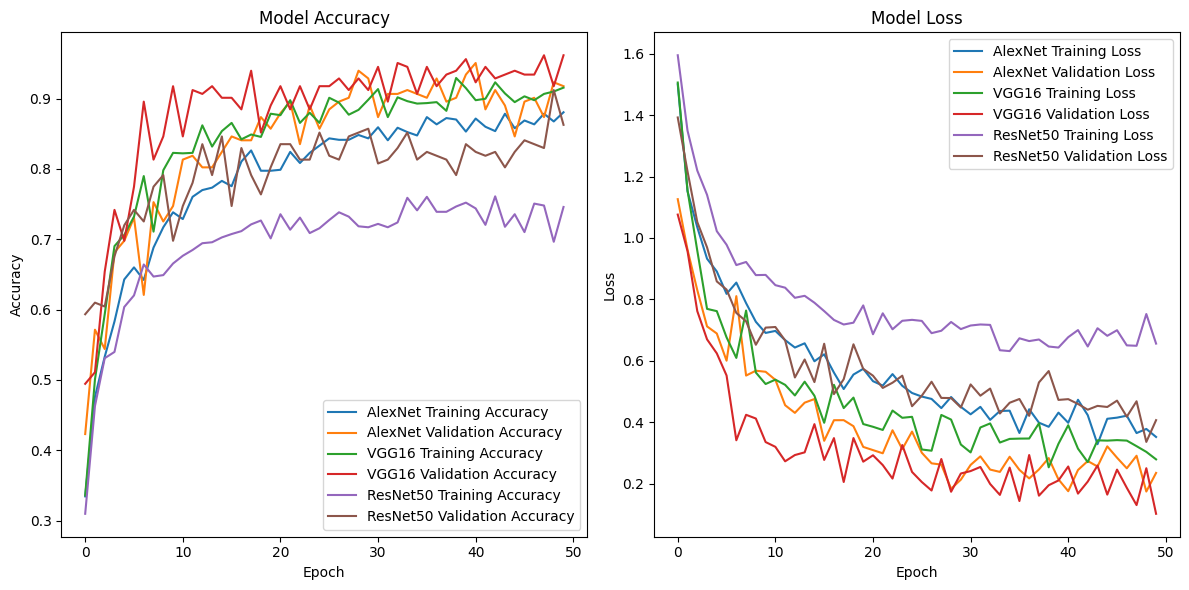

In [19]:
plt.figure(figsize=(12, 6))

# Plot training dan validation accuracy tiap model
plt.subplot(1, 2, 1)
plt.plot(alexnet_history['train_acc'], label='AlexNet Training Accuracy')
plt.plot(alexnet_history['val_acc'], label='AlexNet Validation Accuracy')
plt.plot(vgg16_history['train_acc'], label='VGG16 Training Accuracy')
plt.plot(vgg16_history['val_acc'], label='VGG16 Validation Accuracy')
plt.plot(resnet50_history['train_acc'], label='ResNet50 Training Accuracy')
plt.plot(resnet50_history['val_acc'], label='ResNet50 Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training dan validation loss tiap model
plt.subplot(1, 2, 2)
plt.plot(alexnet_history['train_loss'], label='AlexNet Training Loss')
plt.plot(alexnet_history['val_loss'], label='AlexNet Validation Loss')
plt.plot(vgg16_history['train_loss'], label='VGG16 Training Loss')
plt.plot(vgg16_history['val_loss'], label='VGG16 Validation Loss')
plt.plot(resnet50_history['train_loss'], label='ResNet50 Training Loss')
plt.plot(resnet50_history['val_loss'], label='ResNet50 Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

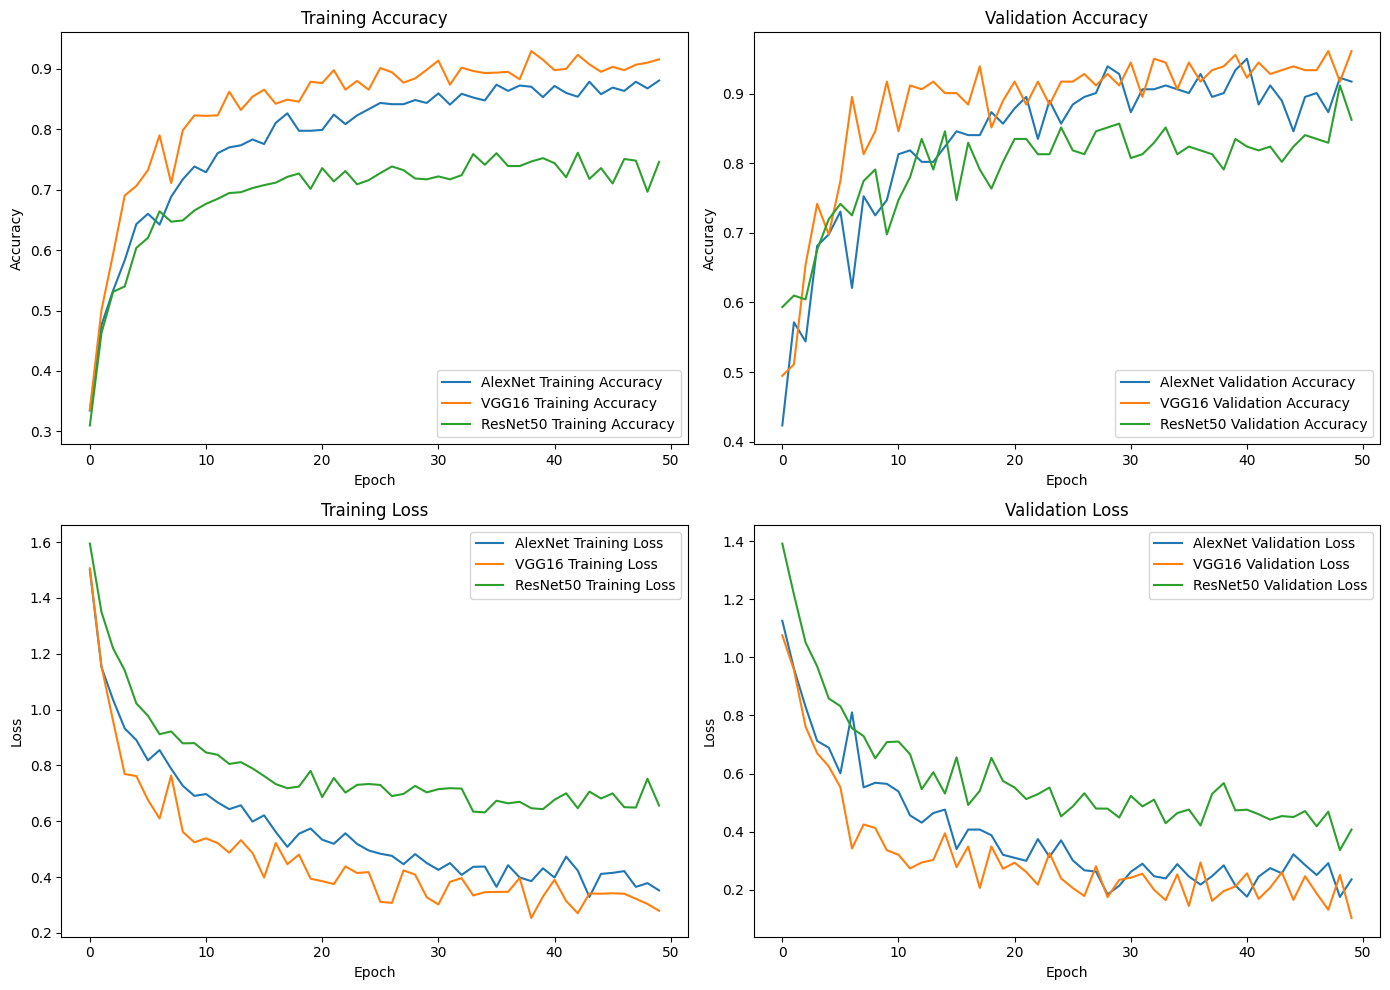

In [20]:
plt.figure(figsize=(14, 10))

# Plot training accuracy tiap model
plt.subplot(2, 2, 1)
plt.plot(alexnet_history['train_acc'], label='AlexNet Training Accuracy')
plt.plot(vgg16_history['train_acc'], label='VGG16 Training Accuracy')
plt.plot(resnet50_history['train_acc'], label='ResNet50 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy tiap model
plt.subplot(2, 2, 2)
plt.plot(alexnet_history['val_acc'], label='AlexNet Validation Accuracy')
plt.plot(vgg16_history['val_acc'], label='VGG16 Validation Accuracy')
plt.plot(resnet50_history['val_acc'], label='ResNet50 Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss tiap model
plt.subplot(2, 2, 3)
plt.plot(alexnet_history['train_loss'], label='AlexNet Training Loss')
plt.plot(vgg16_history['train_loss'], label='VGG16 Training Loss')
plt.plot(resnet50_history['train_loss'], label='ResNet50 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss tiap model
plt.subplot(2, 2, 4)
plt.plot(alexnet_history['val_loss'], label='AlexNet Validation Loss')
plt.plot(vgg16_history['val_loss'], label='VGG16 Validation Loss')
plt.plot(resnet50_history['val_loss'], label='ResNet50 Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 65.3 MB/s eta 0:00:00:00:0100:01


## Percobaan kedua: Mencoba AdamW

In [31]:
alexnet_model = create_model("alexnet",num_classes).to(device)
vgg16_model = create_model("vgg16",num_classes).to(device)
resnet50_model = create_model("resnet50",num_classes).to(device)

In [32]:
# Hyperparameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
alexnet_optimizer = optim.AdamW(alexnet_model.classifier.parameters(), lr=1e-5, weight_decay=1e-5)
vgg16_optimizer = optim.AdamW(vgg16_model.classifier.parameters(), lr=1e-5, weight_decay=1e-5)
resnet50_optimizer = optim.AdamW(resnet50_model.fc.parameters(), lr=1e-5, weight_decay=1e-5)  # Use AdamW, adjust lr

In [33]:
# Train dan evaluasi AlexNet
print("--- Training AlexNet ---")
alexnet_model, alexnet_history = train_model(alexnet_model, train_loader, val_loader, criterion, alexnet_optimizer, num_epochs)
alexnet_accuracy = evaluate_model(alexnet_model, test_loader)
# Save model
torch.save(alexnet_model,'finetuned_alexnet_AdamW_v2.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del alexnet_model
print(f"AlexNet Accuracy on Test Set: {alexnet_accuracy:.4f}")

--- Training AlexNet ---
Epoch 0/49 Loss: 1.5959 Acc: 0.2665 Val Loss: 1.5373 Val Acc: 0.3901
Epoch 1/49 Loss: 1.5172 Acc: 0.3400 Val Loss: 1.4437 Val Acc: 0.5604
Epoch 2/49 Loss: 1.4530 Acc: 0.3997 Val Loss: 1.3683 Val Acc: 0.5604
Epoch 3/49 Loss: 1.3686 Acc: 0.4739 Val Loss: 1.2540 Val Acc: 0.6099
Epoch 4/49 Loss: 1.2838 Acc: 0.4966 Val Loss: 1.1463 Val Acc: 0.6374
Epoch 5/49 Loss: 1.1904 Acc: 0.5563 Val Loss: 1.0500 Val Acc: 0.6538
Epoch 6/49 Loss: 1.0930 Acc: 0.6058 Val Loss: 0.8878 Val Acc: 0.7527
Epoch 7/49 Loss: 1.0255 Acc: 0.6140 Val Loss: 0.8424 Val Acc: 0.7637
Epoch 8/49 Loss: 0.9748 Acc: 0.6422 Val Loss: 0.7681 Val Acc: 0.7747
Epoch 9/49 Loss: 0.9175 Acc: 0.6621 Val Loss: 0.7146 Val Acc: 0.7747
Epoch 10/49 Loss: 0.8788 Acc: 0.6738 Val Loss: 0.6399 Val Acc: 0.7912
Epoch 11/49 Loss: 0.8445 Acc: 0.6944 Val Loss: 0.6357 Val Acc: 0.7912
Epoch 12/49 Loss: 0.7971 Acc: 0.7102 Val Loss: 0.5786 Val Acc: 0.8352
Epoch 13/49 Loss: 0.7723 Acc: 0.7198 Val Loss: 0.5647 Val Acc: 0.8242
Epoch

In [34]:
# Train dan evaluasi VGG16
print("--- Training VGG16 ---")
vgg16_model, vgg16_history = train_model(vgg16_model, train_loader, val_loader, criterion, vgg16_optimizer, num_epochs)
vgg16_accuracy = evaluate_model(vgg16_model, test_loader)
# Save model
torch.save(vgg16_model, 'finetuned_vgg16_AdamW_v2.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del vgg16_model
print(f"VGG16 Accuracy on Test Set: {vgg16_accuracy:.4f}")

--- Training VGG16 ---
Epoch 0/49 Loss: 1.6079 Acc: 0.2424 Val Loss: 1.5680 Val Acc: 0.3022
Epoch 1/49 Loss: 1.5427 Acc: 0.3194 Val Loss: 1.5003 Val Acc: 0.4451
Epoch 2/49 Loss: 1.4817 Acc: 0.3764 Val Loss: 1.3839 Val Acc: 0.5495
Epoch 3/49 Loss: 1.3877 Acc: 0.4457 Val Loss: 1.2489 Val Acc: 0.5824
Epoch 4/49 Loss: 1.2499 Acc: 0.5158 Val Loss: 1.0861 Val Acc: 0.6484
Epoch 5/49 Loss: 1.1079 Acc: 0.5838 Val Loss: 0.9184 Val Acc: 0.7253
Epoch 6/49 Loss: 1.0197 Acc: 0.6010 Val Loss: 0.8201 Val Acc: 0.7527
Epoch 7/49 Loss: 0.9307 Acc: 0.6490 Val Loss: 0.7402 Val Acc: 0.7308
Epoch 8/49 Loss: 0.8291 Acc: 0.6999 Val Loss: 0.6567 Val Acc: 0.8022
Epoch 9/49 Loss: 0.7687 Acc: 0.7163 Val Loss: 0.5643 Val Acc: 0.8407
Epoch 10/49 Loss: 0.6942 Acc: 0.7486 Val Loss: 0.5001 Val Acc: 0.8516
Epoch 11/49 Loss: 0.6760 Acc: 0.7617 Val Loss: 0.4743 Val Acc: 0.8626
Epoch 12/49 Loss: 0.6231 Acc: 0.7898 Val Loss: 0.4835 Val Acc: 0.8352
Epoch 13/49 Loss: 0.5595 Acc: 0.8029 Val Loss: 0.3980 Val Acc: 0.8462
Epoch 1

In [35]:
# Train dan evaluasi ResNet50
print("--- Training ResNet50 ---")
resnet50_model, resnet50_history = train_model(resnet50_model, train_loader, val_loader, criterion, resnet50_optimizer, num_epochs)
resnet50_accuracy = evaluate_model(resnet50_model, test_loader)
# Save model
torch.save(resnet50_model, 'finetuned_resnet50_AdamW_v2.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del resnet50_model
print(f"ResNet50 Accuracy on Test Set: {resnet50_accuracy:.4f}")

--- Training ResNet50 ---
Epoch 0/49 Loss: 1.6077 Acc: 0.2225 Val Loss: 1.5933 Val Acc: 0.2473
Epoch 1/49 Loss: 1.5918 Acc: 0.2706 Val Loss: 1.5848 Val Acc: 0.2363
Epoch 2/49 Loss: 1.5831 Acc: 0.2768 Val Loss: 1.5648 Val Acc: 0.2857
Epoch 3/49 Loss: 1.5715 Acc: 0.2878 Val Loss: 1.5505 Val Acc: 0.2692
Epoch 4/49 Loss: 1.5589 Acc: 0.3104 Val Loss: 1.5544 Val Acc: 0.3462
Epoch 5/49 Loss: 1.5407 Acc: 0.3276 Val Loss: 1.5358 Val Acc: 0.3462
Epoch 6/49 Loss: 1.5331 Acc: 0.3537 Val Loss: 1.5210 Val Acc: 0.3956
Epoch 7/49 Loss: 1.5301 Acc: 0.3475 Val Loss: 1.5055 Val Acc: 0.4505
Epoch 8/49 Loss: 1.5117 Acc: 0.3935 Val Loss: 1.4945 Val Acc: 0.3956
Epoch 9/49 Loss: 1.4975 Acc: 0.3874 Val Loss: 1.4747 Val Acc: 0.5110
Epoch 10/49 Loss: 1.4914 Acc: 0.4183 Val Loss: 1.4644 Val Acc: 0.5385
Epoch 11/49 Loss: 1.4789 Acc: 0.4245 Val Loss: 1.4583 Val Acc: 0.5385
Epoch 12/49 Loss: 1.4593 Acc: 0.4437 Val Loss: 1.4488 Val Acc: 0.5659
Epoch 13/49 Loss: 1.4527 Acc: 0.4622 Val Loss: 1.4363 Val Acc: 0.5549
Epoc

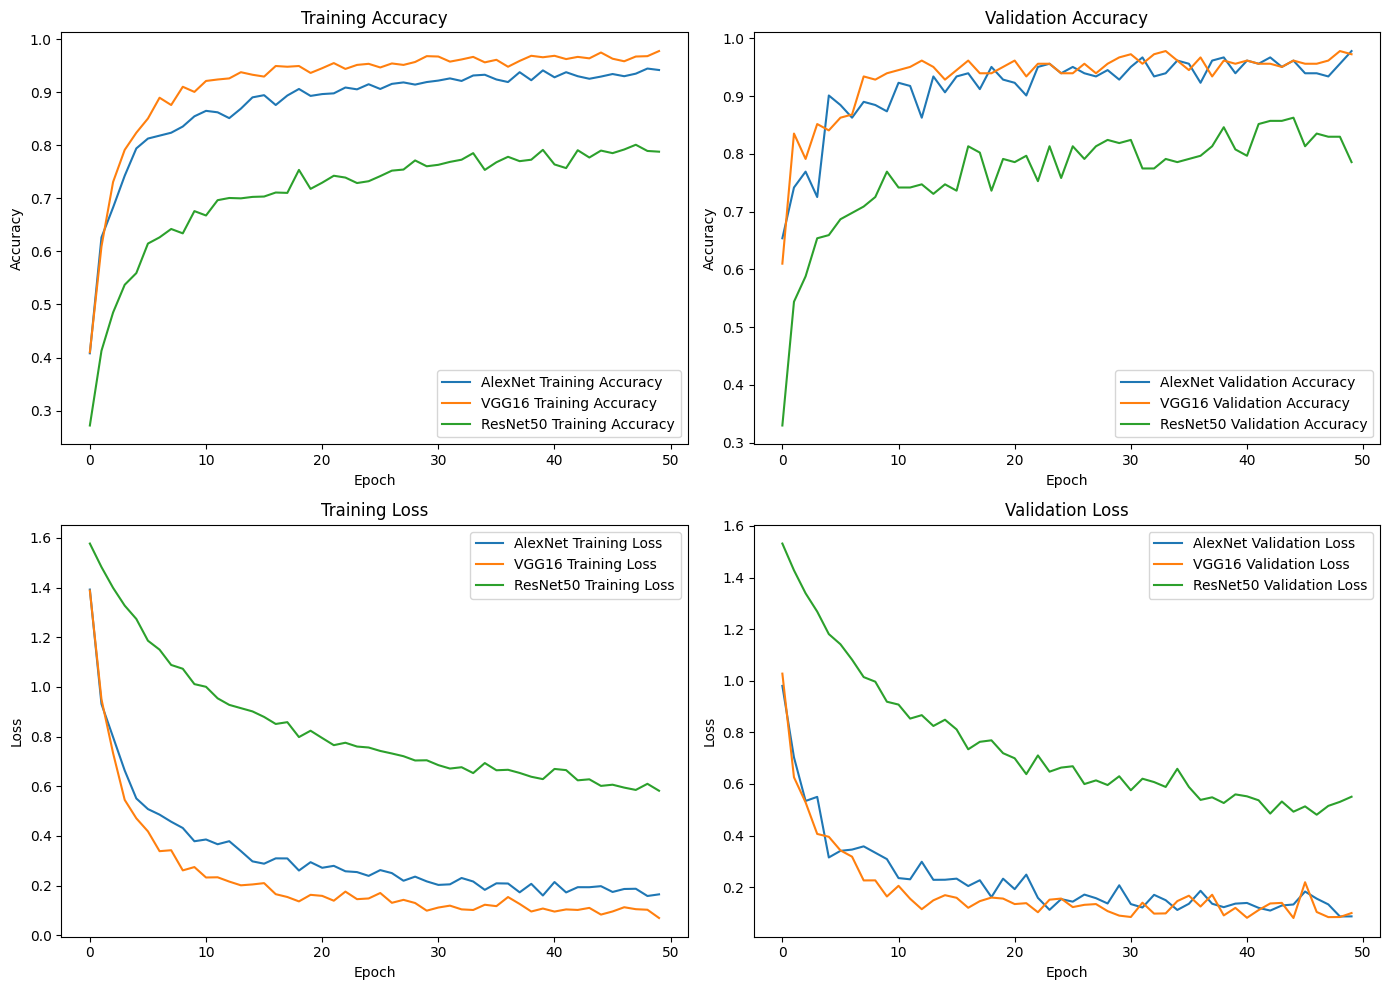

In [30]:
plt.figure(figsize=(14, 10))

# Plot training accuracy tiap model
plt.subplot(2, 2, 1)
plt.plot(alexnet_history['train_acc'], label='AlexNet Training Accuracy')
plt.plot(vgg16_history['train_acc'], label='VGG16 Training Accuracy')
plt.plot(resnet50_history['train_acc'], label='ResNet50 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy tiap model
plt.subplot(2, 2, 2)
plt.plot(alexnet_history['val_acc'], label='AlexNet Validation Accuracy')
plt.plot(vgg16_history['val_acc'], label='VGG16 Validation Accuracy')
plt.plot(resnet50_history['val_acc'], label='ResNet50 Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss tiap model
plt.subplot(2, 2, 3)
plt.plot(alexnet_history['train_loss'], label='AlexNet Training Loss')
plt.plot(vgg16_history['train_loss'], label='VGG16 Training Loss')
plt.plot(resnet50_history['train_loss'], label='ResNet50 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss tiap model
plt.subplot(2, 2, 4)
plt.plot(alexnet_history['val_loss'], label='AlexNet Validation Loss')
plt.plot(vgg16_history['val_loss'], label='VGG16 Validation Loss')
plt.plot(resnet50_history['val_loss'], label='ResNet50 Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
from torchsummary import summary

# Mencoba ALEXNET vs VGG19 vs RESNET152
Dalam percobaan ini, terdapat dua modifikasi yang dilakukan. Pertama, kedalaman lapisan fully connected pada ketiga model arsitektur, yaitu ResNet, AlexNet, dan VGG, akan diseragamkan. Langkah ini bertujuan untuk mengeliminasi pengaruh perbedaan kedalaman lapisan fully connected terhadap kinerja model, sehingga hasil evaluasi dapat dilakukan secara lebih adil dan konsisten.

Kedua, percobaan ini juga menggunakan model terbesar dari masing-masing jenis arsitektur, yaitu VGG19 dan ResNet152. Penggunaan model dengan ukuran terbesar ini dimaksudkan untuk mengeksplorasi kemampuan maksimal dari setiap arsitektur dalam melakukan transfer learning pada tugas klasifikasi yang diberikan.


In [89]:
def replace_classifier(model, num_classes=3):
    if isinstance(model, models.ResNet):
        num_features = model.fc.in_features
        print("Sebelum classifier diganti:")
        print(model.fc)
        
        # Mengganti lapisan klasifikasi terakhir dengan lapisan baru yang sesuai
        model.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
        print("Setelah classifier diganti:")
        print(model.fc)
        
    elif isinstance(model, (models.AlexNet, models.VGG)):
        num_features = model.classifier[6].in_features
        print("Sebelum classifier diganti:")
        print(model.classifier)
        
        # Mengganti lapisan klasifikasi terakhir dengan lapisan baru yang sesuai
        model.classifier[6] = nn.Linear(num_features, num_classes)
        
        print("Setelah classifier diganti:")
        print(model.classifier)
        
    else:
        raise ValueError("Arsitektur model tidak didukung pada program ini")
        
    return model

In [86]:
def create_model(model_name="alexnet", num_classes=3):
    if model_name == "alexnet":
        model = models.alexnet(weights='DEFAULT')
    elif model_name == "vgg19":
        model = models.vgg19(weights='DEFAULT')
    elif model_name == "resnet152":
        model = models.resnet152(weights='DEFAULT')
    else:
        raise ValueError("Ganti piliham model ke 'alexnet', 'vgg11', or 'resnet152'.")

    model = replace_classifier(model, num_classes)
    return model

In [99]:
alexnet_model = create_model("alexnet",num_classes).to(device)
vgg19_model = create_model("vgg19",num_classes).to(device)
resnet152_model = create_model("resnet152",num_classes).to(device)

Sebelum classifier diganti:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Setelah classifier diganti:
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)
Sebelum classifier diganti:
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6

In [100]:
summary(alexnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [101]:
summary(vgg19_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [102]:
summary(resnet152_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [103]:
# Hyperparameters
num_epochs = 50
criterion = nn.CrossEntropyLoss()
alexnet_optimizer = optim.AdamW(alexnet_model.classifier.parameters(), lr=1e-3, weight_decay=1e-5)
vgg19_optimizer = optim.AdamW(vgg19_model.classifier.parameters(), lr=1e-3, weight_decay=1e-5)
resnet152_optimizer = optim.AdamW(resnet152_model.fc.parameters(), lr=1e-3, weight_decay=1e-5)  # Use AdamW, adjust lr

In [104]:
# Train dan evaluasi AlexNet
print("--- Training AlexNet ---")
alexnet_model, alexnet_history = train_model(alexnet_model, train_loader, val_loader, criterion, alexnet_optimizer, num_epochs)
# alexnet_accuracy = evaluate_model(alexnet_model, test_loader)
# Save model
torch.save(alexnet_model,'finetuned_alexnet_AdamW_v3.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del alexnet_model
print(f"AlexNet Accuracy on Test Set: {alexnet_accuracy:.4f}")

--- Training AlexNet ---
Epoch 0/49 Loss: 1.4864 Acc: 0.4732 Val Loss: 0.8870 Val Acc: 0.5934
Epoch 1/49 Loss: 0.9457 Acc: 0.6408 Val Loss: 0.5753 Val Acc: 0.7692
Epoch 2/49 Loss: 0.7287 Acc: 0.7308 Val Loss: 0.5423 Val Acc: 0.8022
Epoch 3/49 Loss: 0.6379 Acc: 0.7734 Val Loss: 0.5040 Val Acc: 0.8187
Epoch 4/49 Loss: 0.5974 Acc: 0.7706 Val Loss: 0.4452 Val Acc: 0.8462
Epoch 5/49 Loss: 0.5649 Acc: 0.7919 Val Loss: 0.4455 Val Acc: 0.7857
Epoch 6/49 Loss: 0.5896 Acc: 0.7830 Val Loss: 0.4280 Val Acc: 0.8297
Epoch 7/49 Loss: 0.5262 Acc: 0.8111 Val Loss: 0.3656 Val Acc: 0.8571
Epoch 8/49 Loss: 0.5587 Acc: 0.8084 Val Loss: 0.4410 Val Acc: 0.8242
Epoch 9/49 Loss: 0.5220 Acc: 0.8118 Val Loss: 0.2671 Val Acc: 0.8901
Epoch 10/49 Loss: 0.4562 Acc: 0.8413 Val Loss: 0.3915 Val Acc: 0.8681
Epoch 11/49 Loss: 0.4822 Acc: 0.8201 Val Loss: 0.3106 Val Acc: 0.8516
Epoch 12/49 Loss: 0.4385 Acc: 0.8386 Val Loss: 0.4452 Val Acc: 0.8077
Epoch 13/49 Loss: 0.3782 Acc: 0.8654 Val Loss: 0.4194 Val Acc: 0.8187
Epoch

In [105]:
# Train d VGG19
print("--- Training VGG19 ---")
vgg19_model, vgg19_history = train_model(vgg19_model, train_loader, val_loader, criterion, vgg19_optimizer, num_epochs)
# vgg19_accuracy = evaluate_model(vgg19_model, test_loader)
# Save model
torch.save(vgg19_model, 'finetuned_vgg19_AdamW_v3.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del vgg19_model
print(f"VGG16 Accuracy on Test Set: {vgg19_accuracy:.4f}")

--- Training VGG19 ---
Epoch 0/49 Loss: 1.6998 Acc: 0.3516 Val Loss: 0.9553 Val Acc: 0.6154
Epoch 1/49 Loss: 0.9394 Acc: 0.6243 Val Loss: 0.7877 Val Acc: 0.6868
Epoch 2/49 Loss: 0.8273 Acc: 0.7143 Val Loss: 0.7156 Val Acc: 0.7198
Epoch 3/49 Loss: 0.7758 Acc: 0.7507 Val Loss: 0.6881 Val Acc: 0.7363
Epoch 4/49 Loss: 0.6984 Acc: 0.7658 Val Loss: 0.3848 Val Acc: 0.8571
Epoch 5/49 Loss: 0.5954 Acc: 0.7981 Val Loss: 0.5889 Val Acc: 0.7857
Epoch 6/49 Loss: 0.6410 Acc: 0.8077 Val Loss: 0.4719 Val Acc: 0.8187
Epoch 7/49 Loss: 0.6626 Acc: 0.7926 Val Loss: 0.3724 Val Acc: 0.8571
Epoch 8/49 Loss: 0.6185 Acc: 0.8159 Val Loss: 0.3476 Val Acc: 0.8901
Epoch 9/49 Loss: 0.6267 Acc: 0.8139 Val Loss: 0.3095 Val Acc: 0.8571
Epoch 10/49 Loss: 0.6410 Acc: 0.8180 Val Loss: 0.5752 Val Acc: 0.8077
Epoch 11/49 Loss: 0.5431 Acc: 0.8372 Val Loss: 0.3499 Val Acc: 0.8956
Epoch 12/49 Loss: 0.5825 Acc: 0.8324 Val Loss: 0.4835 Val Acc: 0.8187
Epoch 13/49 Loss: 0.6244 Acc: 0.8379 Val Loss: 0.2260 Val Acc: 0.8901
Epoch 1

In [106]:
# Train dan evaluasi ResNet152
print("--- Training ResNet152 ---")
resnet152_model, resnet152_history = train_model(resnet152_model, train_loader, val_loader, criterion, resnet152_optimizer, num_epochs)
# resnet152_accuracy = evaluate_model(resnet152_model, test_loader)
# Save model
torch.save(resnet152_model, 'finetuned_resnet152_AdamW_v3.pt')
# Clear model untuk mengurangi penggunaan resource komputer
del resnet152_model
print(f"ResNet50 Accuracy on Test Set: {resnet152_accuracy:.4f}")

--- Training ResNet152 ---
Epoch 0/49 Loss: 1.4242 Acc: 0.3599 Val Loss: 1.0269 Val Acc: 0.5220
Epoch 1/49 Loss: 0.9650 Acc: 0.6106 Val Loss: 0.7212 Val Acc: 0.7198
Epoch 2/49 Loss: 0.8028 Acc: 0.7047 Val Loss: 0.4946 Val Acc: 0.8352
Epoch 3/49 Loss: 0.6559 Acc: 0.7473 Val Loss: 0.5185 Val Acc: 0.8022
Epoch 4/49 Loss: 0.5996 Acc: 0.7878 Val Loss: 0.4888 Val Acc: 0.8297
Epoch 5/49 Loss: 0.5905 Acc: 0.7720 Val Loss: 0.3679 Val Acc: 0.8791
Epoch 6/49 Loss: 0.5124 Acc: 0.8049 Val Loss: 0.3862 Val Acc: 0.8626
Epoch 7/49 Loss: 0.5318 Acc: 0.8015 Val Loss: 0.3859 Val Acc: 0.8681
Epoch 8/49 Loss: 0.5012 Acc: 0.8118 Val Loss: 0.3512 Val Acc: 0.8571
Epoch 9/49 Loss: 0.4783 Acc: 0.8228 Val Loss: 0.3366 Val Acc: 0.8681
Epoch 10/49 Loss: 0.4306 Acc: 0.8496 Val Loss: 0.3883 Val Acc: 0.8681
Epoch 11/49 Loss: 0.4310 Acc: 0.8441 Val Loss: 0.3082 Val Acc: 0.8846
Epoch 12/49 Loss: 0.4778 Acc: 0.8352 Val Loss: 0.3227 Val Acc: 0.8791
Epoch 13/49 Loss: 0.4616 Acc: 0.8400 Val Loss: 0.3404 Val Acc: 0.8736
Epo

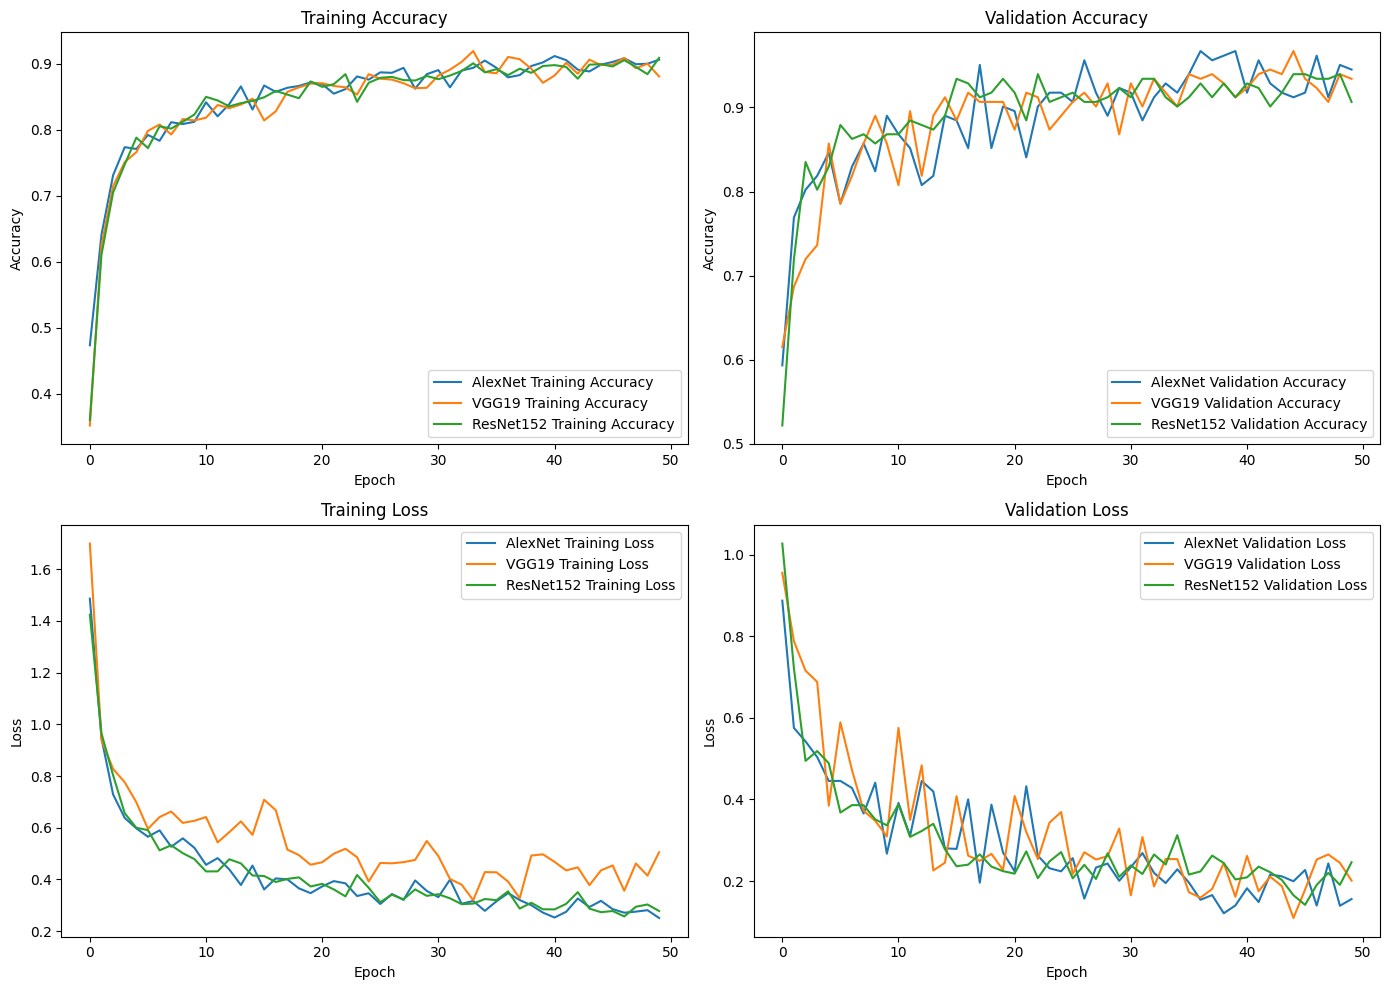

In [109]:
plt.figure(figsize=(14, 10))

# Plot training accuracy tiap model
plt.subplot(2, 2, 1)
plt.plot(alexnet_history['train_acc'], label='AlexNet Training Accuracy')
plt.plot(vgg19_history['train_acc'], label='VGG19 Training Accuracy')
plt.plot(resnet152_history['train_acc'], label='ResNet152 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation accuracy tiap model
plt.subplot(2, 2, 2)
plt.plot(alexnet_history['val_acc'], label='AlexNet Validation Accuracy')
plt.plot(vgg19_history['val_acc'], label='VGG19 Validation Accuracy')
plt.plot(resnet152_history['val_acc'], label='ResNet152 Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss tiap model
plt.subplot(2, 2, 3)
plt.plot(alexnet_history['train_loss'], label='AlexNet Training Loss')
plt.plot(vgg19_history['train_loss'], label='VGG19 Training Loss')
plt.plot(resnet152_history['train_loss'], label='ResNet152 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss tiap model
plt.subplot(2, 2, 4)
plt.plot(alexnet_history['val_loss'], label='AlexNet Validation Loss')
plt.plot(vgg19_history['val_loss'], label='VGG19 Validation Loss')
plt.plot(resnet152_history['val_loss'], label='ResNet152 Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluasi AlexNet

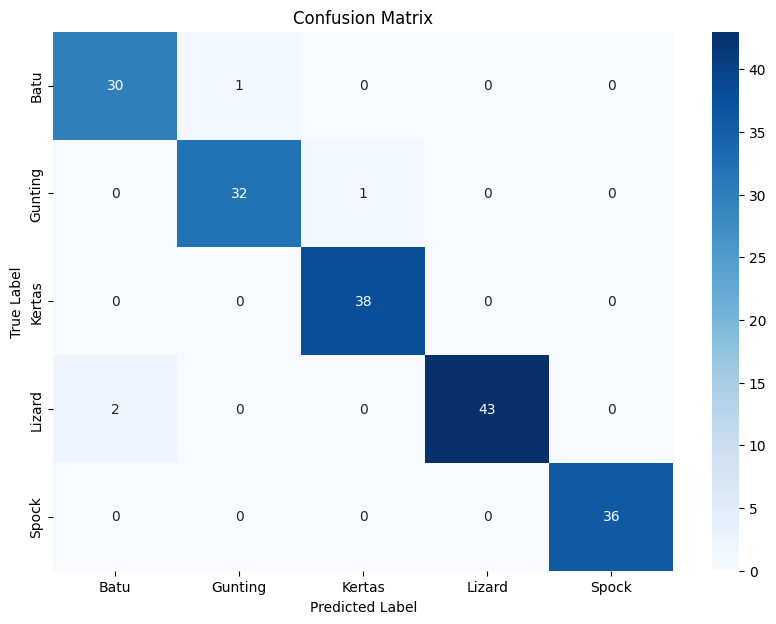

              precision    recall  f1-score   support

        Batu       0.94      0.97      0.95        31
     Gunting       0.97      0.97      0.97        33
      Kertas       0.97      1.00      0.99        38
      Lizard       1.00      0.96      0.98        45
       Spock       1.00      1.00      1.00        36

    accuracy                           0.98       183
   macro avg       0.98      0.98      0.98       183
weighted avg       0.98      0.98      0.98       183



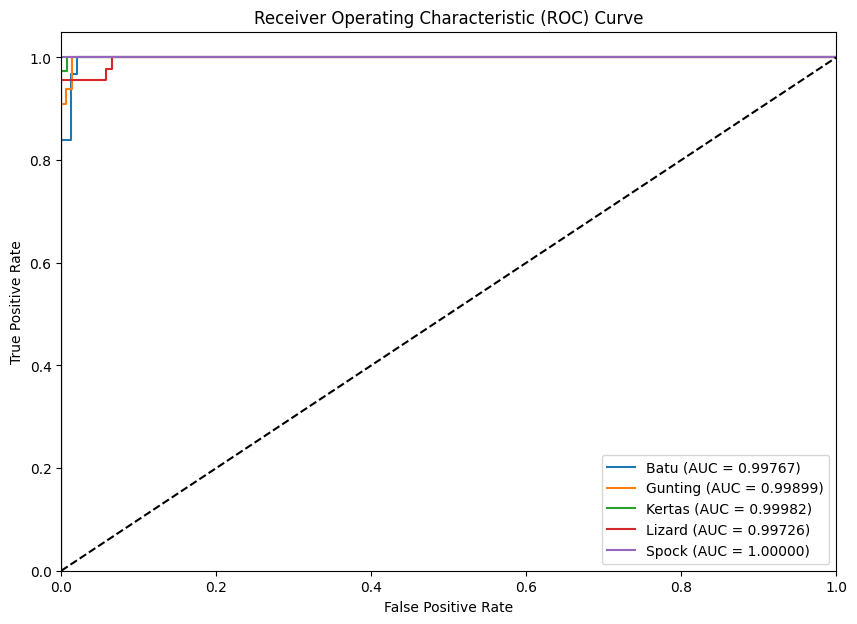

0.9781420765027322

In [147]:
alexnet_model= torch.load('finetuned_alexnet_AdamW_v3.pt')
evaluate_model(alexnet_model, test_loader, class_labels)


## Evaluasi VGG19

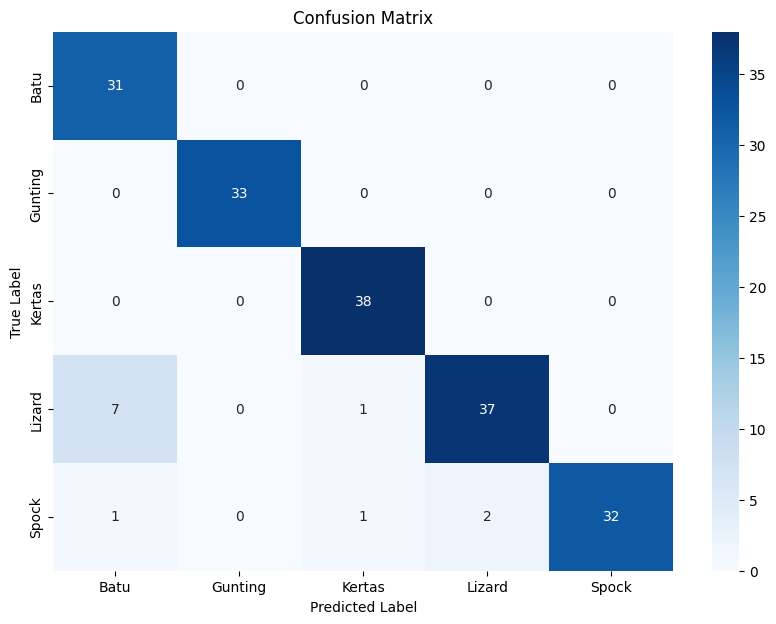

              precision    recall  f1-score   support

        Batu       0.79      1.00      0.89        31
     Gunting       1.00      1.00      1.00        33
      Kertas       0.95      1.00      0.97        38
      Lizard       0.95      0.82      0.88        45
       Spock       1.00      0.89      0.94        36

    accuracy                           0.93       183
   macro avg       0.94      0.94      0.94       183
weighted avg       0.94      0.93      0.93       183



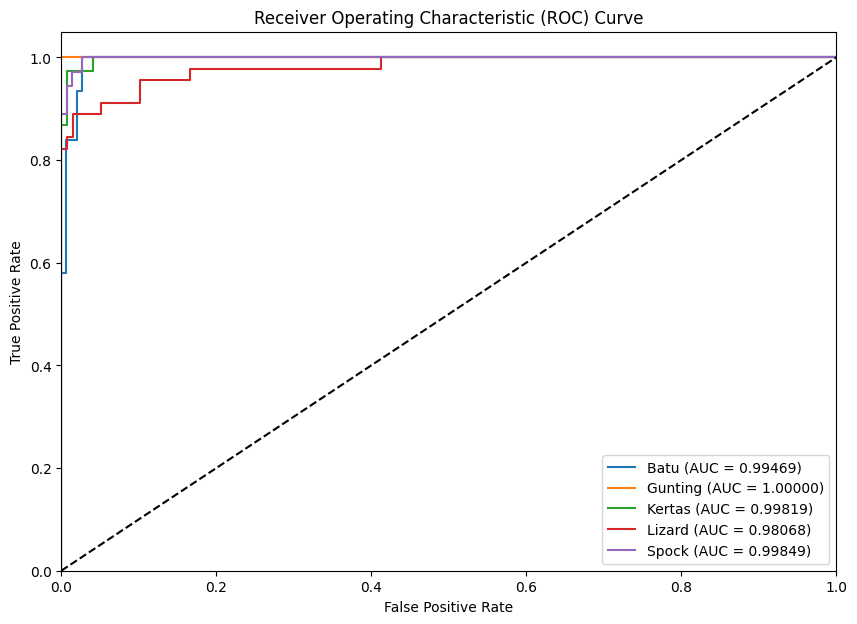

0.9344262295081968

In [149]:
vgg19_model= torch.load('finetuned_vgg19_AdamW_v3.pt')
evaluate_model(vgg19_model, test_loader, class_labels)


## Evaluasi ResNet152

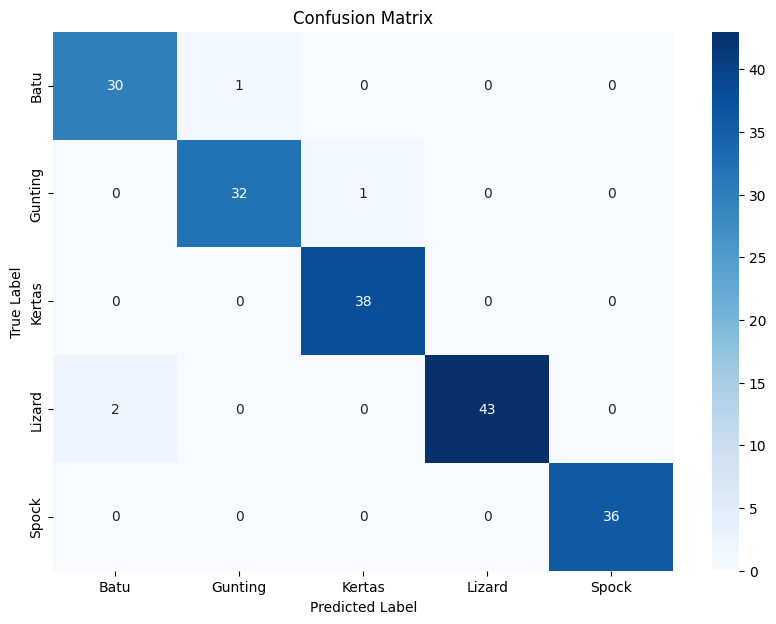

              precision    recall  f1-score   support

        Batu       0.94      0.97      0.95        31
     Gunting       0.97      0.97      0.97        33
      Kertas       0.97      1.00      0.99        38
      Lizard       1.00      0.96      0.98        45
       Spock       1.00      1.00      1.00        36

    accuracy                           0.98       183
   macro avg       0.98      0.98      0.98       183
weighted avg       0.98      0.98      0.98       183



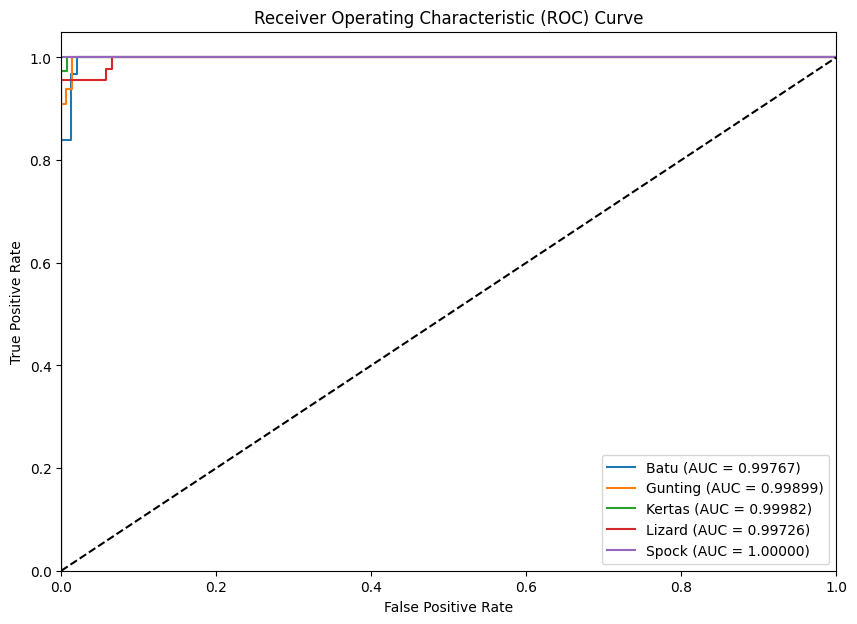

0.9781420765027322

In [150]:
resnet152_model= torch.load('finetuned_resnet152_AdamW_v3.pt')
evaluate_model(alexnet_model, test_loader, class_labels)
